# FarmVibes.AI Crop Segmentation - Local Training

This notebook demonstrates how to train a neural network to segment crops on NDVI timeseries and [Crop Data Layer](https://data.nal.usda.gov/dataset/cropscape-cropland-data-layer#:~:text=The%20Cropland%20Data%20Layer%20%28CDL%29%2C%20hosted%20on%20CropScape%2C,as%20well%20as%20boundary%2C%20water%20and%20road%20layers.) (CDL) maps provided by FarmVibes.AI platform.


### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda env create -f ./crop_env.yaml
$ conda activate crop-seg
```


### Notebook outline
In this notebook, we will train a crop land segmentation model locally using the NDVI rasters and CDL maps generated by FarmVibes.AI in the [Dataset Generation Notebook](./01_dataset_generation.ipynb). Once the model is trained, we will export it to be used later for inference.

Below are the main libraries used for this example and other useful links:
- [Pytorch](https://github.com/pytorch/pytorch) is used as our deep learning framework.
- [TorchGeo](https://github.com/microsoft/torchgeo) is a library built for training models on geospatial data. We use it to dinamically sample fixed-sized chips to train/evaluate our model. We define torchgeo dataset at lib/datasets.py
- [Pytorch-Lightning](https://github.com/Lightning-AI/lightning) is wrapper over pytorch to reduce boilerplate code for training and evaluating models. We define lightning modules at lib/modules.py.
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.
- [Geopandas](https://github.com/geopandas/geopandas) is an extension of the popular pandas library to add support for geographic data. It uses shapely objects in its geometry column, and understands coordinate systems. We use it to visualize the training/validation RoIs. It is also quite useful for transforming geometries between different CRSs.
- [xarray](https://github.com/pydata/xarray) and the extension [rioxarray](https://github.com/corteva/rioxarray) are used for merging and visualizing predictions.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.
- [onnx](https://onnx.ai/get-started.html) is a library for exporting machine learning models to a interoperable format. 

### Code organization
The training code is mainly organized into four parts:

- The datasets (`notebook_lib/datasets.py`) inherit from torchgeo's `RasterDataset` and are used to read and preprocess the CDL and NDVI data produced by FarmVibes.AI platform. For those familiar with pytorch, these datasets are indexed by a spatiotemporal bounding box instead of integer. If you want to add new datasets, you can use these as a base (and check [torchgeo documentation](https://torchgeo.readthedocs.io/en/latest/)).
- The lightning data module (`notebook_lib/modules.py`) contains the code for samplers and data loaders. If you want to change the data split, how to load data, which crops to use, this is probably where you should go to. Also check [pytorch-lightning documentation](https://pytorch-lightning.readthedocs.io/en/latest/).
- The lightning module (`notebook_lib/models.py`) contains the code for running/training/evaluating the neural network: instantiating the neural network, training steps, computing metrics, and others. If you want to change the architecure, the loss, and generally how the model is trained, this is probably where you should go to. Also check [pytorch-lightning documentation](https://pytorch-lightning.readthedocs.io/en/latest/).
- Two utility subpackages (`notebook_lib/utils.py` and `notebook_lib/constants.py`) with supporting code for monitoring the workflow execution, defining crop indexes constants, etc.

---------

### Imports & Constants

In [1]:
# Utility imports
from datetime import datetime
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# FarmVibes.AI imports
from vibe_core.client import get_default_vibe_client

# Pytorch-related imports
import torch
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import onnx

# Imports for this example notebook 
from notebook_lib.utils import bbox_to_shapely, format_timestamp
from notebook_lib.modules import CropSegDataModule
from notebook_lib.models import SegmentationModel, ModelPlusSigmoid
import notebook_lib.constants as constants


##### CONSTANTS
# Dataloader / Model parameters
ROOT_DIR = "./model_checkpoint"

# Leave empty to train
CHPT_PATH = ""
# Add path to load checkpoint
# CHPT_PATH = "notebooks/crop_segmentation/model_checkpoint/lightning_logs/version_0/checkpoints/epoch=9-step=320.ckpt"

CHIP_SIZE = 256
EPOCH_SIZE = 1024
BATCH_SIZE = 16
NDVI_STACK_BANDS = 37
NUM_WORKERS = 1  # Change this depending on available memory and number of cores
VAL_RATIO = 0.3 # Ratio of the validation subset of the input region 

# Training hyperparameters
LR = 1e-3  # Learning rate
WD = 1e-2  # Weight decay
MAX_EPOCHS = 10  # How many epochs to train for

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


### Retrieve the dataset with FarmVibes.AI platform

We will retrieve the dataset from FarmVibes.AI cache by running the dataset generation workflow once again:

In [2]:
input_geometry_path = "./input_region.wkt"
time_range = (datetime(2020, 1, 1), datetime(2020, 12, 31))

# Reading the geometry file 
with open(input_geometry_path) as f:
    geometry = wkt.load(f)


# Instantiate the client
client = get_default_vibe_client()

# Run the workflow
wf_run = client.run("ml/dataset_generation/datagen_crop_segmentation", 
                    "Retrieve dataset cached outputs",
                    geometry=geometry, 
                    time_range=time_range
                    )

wf_run.monitor()

cdl_rasters = wf_run.output["cdl"]
ndvi_rasters = wf_run.output["ndvi"]

Output()

### Preprocess data and instantiate a DataLoader
With the NDVI rasters and CDL maps yielded by FarmVibes.AI, we will use the `CropDataModule` (from `notebook_lib.modules.py`) to preprocess them and provide a DataLoader for the training and evaluation. 

As each CDL map represents a single year, we will combine multiple NDVI rasters along the year, stacking in the channel dimension a number of rasters equal to `NDVI_STACK_BANDS`. In this notebook, we set `NDVI_STACK_BANDS = 37`, which means a 10-day interval between each ndvi raster of a year.

The preprocess consists of stacking the NDVI rasters and upsampling the CDL maps. For this notebook, the DataLoader also splits the ROI in two disjoint regions and extracts chips within each of them for training and validation.

`CropDataModule` has the following arguments:

- `ndvi_rasters`: NDVI rasters generated by FarmVibes.AI workflow.
- `cdl_rasters`: CDL maps downloaded by FarmVibes.AI workflow.
- `ndvi_stack_bands`: how many daily NDVI maps will be stacked to be used as input for training. Default: 37
- `img_size`: tuple that defines the size of each chip that is fed to the network. Default: (256, 256)
- `epoch_size`: how many samples are sampled during training for one epoch (this is for the random sampler used in training). Default: 1024
- `batch_size`: how many samples are fed to the network in a single batch. Default: 16
- `num_workers`: how many worker processes to use in the data loader. Default: 4
- `val_ratio`: how much of the data to separate for validation. Default: 0.2
- `positive_indices`: which CDL indices are considered as positive samples. Crop types with a minimum of 1e5 pixels in the RoI are available in the module `notebook_lib.constants`. You can combine multiple constants by adding them (e.g., `constants.POTATO_INDEX + constants.CORN_INDEX`) Default: `constants.CROP_INDICES`
- `train_years`: list of years used for training. Please, update this in case you are using a different time range. Default: [2020]
- `val_years`: list of years used for validation. Please, update this in case you are using a different time range. Default: [2020]

In [3]:
data = CropSegDataModule(
    ndvi_rasters,
    cdl_rasters,
    ndvi_stack_bands=NDVI_STACK_BANDS,
    img_size=(CHIP_SIZE, CHIP_SIZE),
    epoch_size=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    positive_indices=constants.CROP_INDICES,
    val_ratio=VAL_RATIO,
    train_years=[2020],
    val_years=[2020],
)

data.setup()

Converting CDLMask CRS from EPSG:5070 to EPSG:32611
Converting CDLMask resolution from 30.0 to 10.0


### Train/Validation splits
When generating the training and validation chips, we consider two disjoint regions within the ROI (defined by the `val_ratio` parameter of `CropSegDataModule`). During model optimization, we sample random chips withing the training ROI, whereas validation is done on chips extracted in a grid throughout the validation ROI.

We can visualize the training and validation split by sampling boxes as shown below. By default, we separate 20% of the available data for validation (shown in orange), while the rest is used for training.

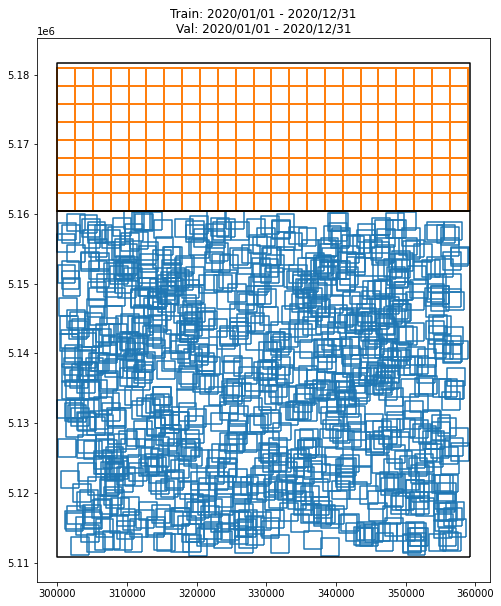

In [4]:
train_roi = data.train_dataloader().sampler.roi
val_roi = data.val_dataloader().sampler.roi

plt.figure(figsize=(10, 10))
ax = plt.gca()
gpd.GeoSeries([bbox_to_shapely(b) for b in data.train_dataloader().sampler]).boundary.plot(ax=ax, color="C0")
gpd.GeoSeries([bbox_to_shapely(b) for b in data.val_dataloader().sampler]).boundary.plot(ax=ax, color="C1")
gpd.GeoSeries(bbox_to_shapely(train_roi)).boundary.plot(ax=ax, color="black")
gpd.GeoSeries(bbox_to_shapely(val_roi)).boundary.plot(ax=ax, color="black")
plt.title(
    f"Train: {format_timestamp(train_roi.mint)} - {format_timestamp(train_roi.maxt)}\n"
    f"Val: {format_timestamp(val_roi.mint)} - {format_timestamp(val_roi.maxt)}"
)
plt.show()

### Model Definition

We will train a Unet that receives the stacked NDVI rasters and outputs a crop segmentation map. To optimize our model, we employ pixel-wise cross-entropy loss between the network's prediction and the CDL map for the same chip.

The `SegmentationModel` defines the network architecture and training parameters. It has the following arguments:

- `lr`: learning rate.
- `weight_decay`: amount of weight decay regularization.
- `in_channels`: number of input channels of the network. Needs to match the number of bands/channels of the stacked NVDI raster.
- `encoder_name`: name of the encoder used for the Unet. See segmentation_models_pytorch for more information. Default: 'resnet34'
- `encoder_weights`: name of the pretrained weights for the encoder. Use 'imagenet' or None (random weights). See [segmentation_models_pytorch](https://smp.readthedocs.io/en/latest/index.html) for more information. Default: 'imagenet'
- `classes`: number of output classes. As we are doing a binary crop vs. non-crop segmentation, we use the default value. Default: 1
- `num_epochs`: number of training epochs. Used for the cosine annealing scheduler. Default: 10


When training for specific crops you might want to tune the loss (specifically due to imbalance, the amount of positive pixels will be really small compared to negative ones). Feel free to play around with other parameters such as learning rate, weight decay, etc.

In [5]:
model = SegmentationModel(lr=LR, 
                        weight_decay=WD, 
                        in_channels=NDVI_STACK_BANDS,
                        num_epochs=MAX_EPOCHS,
                        classes=1,
                        )

# Default checkpoint callback will save a checkpoint at the end of every epoch
callbacks = [ModelCheckpoint()]

# Change to gpus=0 to run on CPU
trainer = Trainer(max_epochs=MAX_EPOCHS, callbacks=callbacks, default_root_dir=ROOT_DIR, gpus = 0)

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training
We can train the model by calling the trainer's fit method and passing the lightning module and data module.

In [6]:
if CHPT_PATH and os.path.exists(CHPT_PATH):
    # Load model
    model = SegmentationModel.load_from_checkpoint(CHPT_PATH)
else:
    # Train it now
    trainer.fit(model, data)

Missing logger folder: model_checkpoint/lightning_logs

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | FPN               | 23.3 M
1 | loss          | BCEWithLogitsLoss | 0     
2 | train_metrics | MetricCollection  | 0     
3 | val_metrics   | MetricCollection  | 0     
----------------------------------------------------
23.3 M    Trainable params
0         Non-trainable params
23.3 M    Total params
93.048    Total estimated model params size (MB)


Converting CDLMask CRS from EPSG:5070 to EPSG:32611
Converting CDLMask resolution from 30.0 to 10.0


Sanity Checking: 0it [00:00, ?it/s]

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of th

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Evaluation
We can evaluate the model by calling the validate method from the Pytorch-Lightning trainer. This will compute and print metrics for the validation set. Additionally, we plot the Precision-Recall curve, and display the operating point for a threshold of 0.5.

In [7]:
trainer.validate(model, data)

Converting CDLMask CRS from EPSG:5070 to EPSG:32611
Converting CDLMask resolution from 30.0 to 10.0


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9236927628517151     │
│          val_ap           │    0.9552967548370361     │
│         val_loss          │    0.19599609076976776    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.19599609076976776,
  'val_acc': 0.9236927628517151,
  'val_ap': 0.9552967548370361}]

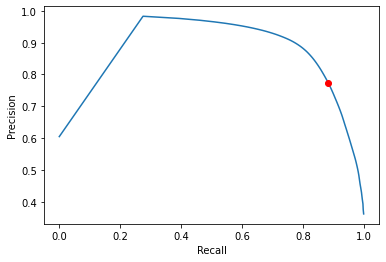

In [11]:
FPs = model.val_metrics["ap"].FPs
TPs = model.val_metrics["ap"].TPs
FNs = model.val_metrics["ap"].FNs

Re = TPs / (TPs + FNs)
Pr = TPs / (TPs + FPs)

plt.plot(Re[0], Pr[0])
plt.plot(Re[0, 50], Pr[0, 50], 'ro')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Saving the model to ONNX format

[Open Neural Network Exchange](https://onnx.ai/) (ONNX) is a open source format that represents machine learning models, both deep learning and traditional ML. It is supported by many frameworks, tools and hardware, enabling interoperability between different components easily. Exporting our trained model in ONNX format allows us to load it and perform inference over new data under different hardware setups and even within FarmVibes.AI platform. For additional resources, refer to the [ONNX](https://onnx.ai/get-started.html) or [PyTorch](https://pytorch.org/docs/master/onnx.html) documentations.

In [ ]:
# Set model to inference mode before exporting to ONNX
trace_model = ModelPlusSigmoid(model).eval()    

dummy_input = torch.randn(BATCH_SIZE, NDVI_STACK_BANDS, CHIP_SIZE, CHIP_SIZE)

onnx_output_path = os.path.join(ROOT_DIR, "crop_segmentation_model.onnx")

# Export the model
torch.onnx.export(trace_model,                                            
                  dummy_input,                                           # model example input
                  onnx_output_path,                                      # where to save the model (can be a file or file-like object)
                  export_params=True,                                    # store the trained parameter weights inside the model file
                  do_constant_folding=True,                              # whether to execute constant folding for optimization
                  input_names=['ndvi_stack'],                            # the model's input names
                  output_names=['seg_map'],                              # the model's output names
                  dynamic_axes={'ndvi_stack' : {0 : 'batch_size'},       # variable length axes
                                'seg_map' : {0 : 'batch_size'}}) 

Let's use ONNX checker to verify the model was exported successfully: 

In [13]:
onnx_model = onnx.load(onnx_output_path)
onnx.checker.check_model(onnx_model)

---------

### Next steps

With the model trained and exported into an ONNX file, we recommend following to the [Inference Notebook](./04_inference.ipynb) to see how the model can be used within FarmVibes.AI cluster for segmenting new regions.
Besides that, we also recommend checking the [AML Training Notebook](./03_aml_training.ipynb), for an example on leveraging the computing capabilities of Azure Machine Learning to train the segmentation model.